In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline  

Using Theano backend.


In [3]:
def train_test_split(data, p=None):
    if p:
        split_index = int(len(data) * p)

    train = data[:split_index]
    test = data[split_index:]
    return train, test, split_index

In [4]:
def lag_data(data, lag=1):
    data = list(data)
    X, y = [], []
    for i in range(len(data) - lag - 1):
        a = data[i: i + lag]
        X.append(a)
        y.append(data[i + lag])
    return np.array(X), np.array(y)

In [6]:
def split_data(df, return_full=False, p=0.7):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(df)
    train, test, split_index = train_test_split(data, p=p)
    X_train, y_train = lag_data(train, lag=lags)
    X_test, y_test = lag_data(test, lag=lags)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    if return_full:
        return X_train, y_train, X_test, y_test, scaler, data
        
    return X_train, y_train, X_test, y_test, scaler

In [40]:
def train_model(X_train, y_train, batch_size, epochs=10, run_state_model=True):
    model = create_network(lags, batch_size, retain_state=False)
    model.fit(X_train, y_train, nb_epoch=epochs, batch_size=14, verbose=0)

    if run_state_model:
        state_model = create_network(lags, batch_size, retain_state=True)

        for i in range(epochs):
            state_model.fit(X_train, y_train, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
            state_model.reset_states()

        return model, state_model
    
    return model

In [47]:
def train_model_short(X_train, y_train, batch_size, epochs=10, run_state_model=True):
    model = create_network_short(lags, batch_size, retain_state=False)
    model.fit(X_train, y_train, nb_epoch=epochs, batch_size=14, verbose=0)

    if run_state_model:
        state_model = create_network(lags, batch_size, retain_state=True)

        for i in range(epochs):
            state_model.fit(X_train, y_train, nb_epoch=1, batch_size=batch_size, verbose=2, shuffle=False)
            state_model.reset_states()

        return model, state_model
    
    return model

In [49]:
def create_network_short(lags, batch_size, retain_state):
    if retain_state is False:
        batch_size = 1
    model = Sequential()
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
#     model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
#     model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(14, batch_input_shape=(batch_size, lags, 1), stateful=retain_state))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    return model

In [7]:
def create_network(lags, batch_size, retain_state):
    if retain_state is False:
        batch_size = 1
    model = Sequential()
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(28, batch_input_shape=(batch_size, lags, 1), return_sequences=True, dropout_W=0.1, dropout_U=0.1, stateful=retain_state))
    model.add(LSTM(14, batch_input_shape=(batch_size, lags, 1), stateful=retain_state))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    return model

In [8]:
def evaluate_one_step_model(model, scaler, X_train, X_test, y_train, y_test, batch_size=None):
    if batch_size:
        train_preds = model.predict(X_train, batch_size)
        test_preds = model.predict(X_test, batch_size)
    else:
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)

    train_score = math.sqrt(mean_squared_error(y_train, train_preds))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = math.sqrt(mean_squared_error(y_test, test_preds))
    print('Test Score: %.2f RMSE' % (test_score))
    
    return test_preds

# 1-Step Forecast

## Arrivals

In [9]:
arr = pd.read_csv("../data/Sample/333_arrivals.csv", header=None)[1]
arr.head()

0     2
1    21
2    13
3     5
4     7
Name: 1, dtype: int64

In [11]:
lags = 14
standard_batch_size = 6

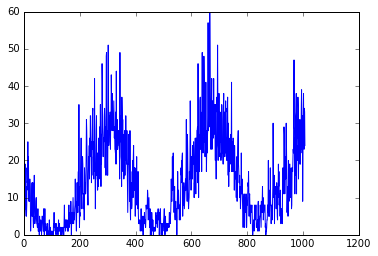

In [12]:
plt.plot(arr)
plt.show()

In [13]:
scale_X_train, scale_y_train, scale_X_test, scale_y_test, scaler = split_data(arr)
unscaled_y_train = scaler.inverse_transform(scale_y_train)
unscaled_y_test = scaler.inverse_transform(scale_y_test)

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer

In [14]:
print len(scale_X_train)

690


In [15]:
model, state_model = train_model(scale_X_train, scale_y_train, standard_batch_size)

Epoch 1/1
1s - loss: 0.0399
Epoch 1/1
1s - loss: 0.0554
Epoch 1/1
1s - loss: 0.0492
Epoch 1/1
1s - loss: 0.0281
Epoch 1/1
1s - loss: 0.0221
Epoch 1/1
1s - loss: 0.0239
Epoch 1/1
1s - loss: 0.0231
Epoch 1/1
1s - loss: 0.0223
Epoch 1/1
1s - loss: 0.0200
Epoch 1/1
1s - loss: 0.0224


### No Memory

In [16]:
test_preds = evaluate_one_step_model(model, scaler, scale_X_train, scale_X_test, unscaled_y_train, unscaled_y_test)

Train Score: 7.82 RMSE
Test Score: 7.33 RMSE


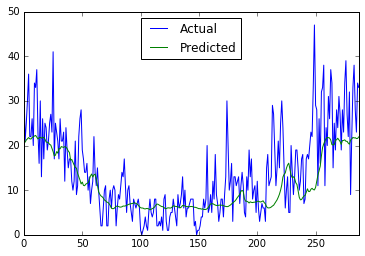

In [17]:
results = pd.concat([pd.Series(unscaled_y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

### Memory Between Batches

In [18]:
test_preds = evaluate_one_step_model(state_model, scaler, scale_X_train, scale_X_test, unscaled_y_train, unscaled_y_test, standard_batch_size)

Train Score: 10.09 RMSE
Test Score: 10.54 RMSE


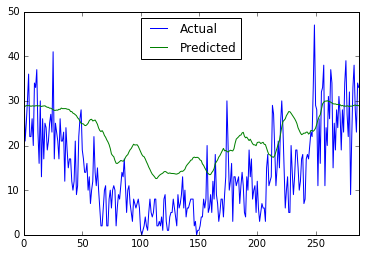

In [19]:
results = pd.concat([pd.Series(unscaled_y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

## Departures

In [20]:
dep = pd.read_csv("../data/Sample/333_departures.csv", header=None)[1]
dep.head()

0     3
1    18
2     6
3     6
4     9
Name: 1, dtype: int64

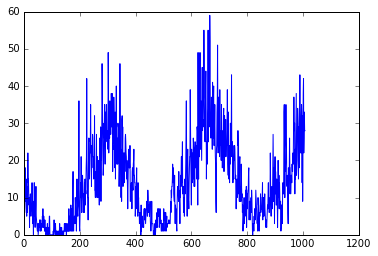

In [21]:
plt.plot(dep)
plt.show()

In [22]:
scale_X_train, scale_y_train, scale_X_test, scale_y_test, scaler = split_data(dep)
unscaled_y_train = scaler.inverse_transform(scale_y_train)
unscaled_y_test = scaler.inverse_transform(scale_y_test)

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer

In [23]:
print len(scale_X_train)

690


In [24]:
model, state_model = train_model(scale_X_train, scale_y_train, standard_batch_size)

Epoch 1/1
1s - loss: 0.0223
Epoch 1/1
1s - loss: 0.0454
Epoch 1/1
1s - loss: 0.0420
Epoch 1/1
1s - loss: 0.0275
Epoch 1/1
1s - loss: 0.0253
Epoch 1/1
1s - loss: 0.0219
Epoch 1/1
1s - loss: 0.0195
Epoch 1/1
1s - loss: 0.0197
Epoch 1/1
1s - loss: 0.0190
Epoch 1/1
1s - loss: 0.0182


### No Memory

In [25]:
test_preds = evaluate_one_step_model(model, scaler, scale_X_train, scale_X_test, unscaled_y_train, unscaled_y_test)

Train Score: 7.49 RMSE
Test Score: 6.86 RMSE


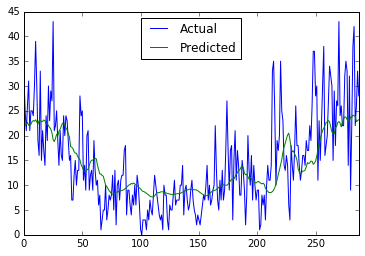

In [26]:
results = pd.concat([pd.Series(unscaled_y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

### Memory Between Batches

In [27]:
test_preds = evaluate_one_step_model(state_model, scaler, scale_X_train, scale_X_test, unscaled_y_train, unscaled_y_test, standard_batch_size)

Train Score: 8.20 RMSE
Test Score: 8.86 RMSE


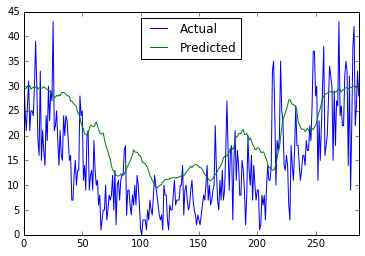

In [28]:
results = pd.concat([pd.Series(unscaled_y_test), pd.Series(map(lambda x: x[0], test_preds))], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

# 7-Step Forecast

In [62]:
scale_X_train, scale_y_train, scale_X_test, scale_y_test, scaler, full = split_data(arr, True, p=0.7)
unscaled_y_train = scaler.inverse_transform(scale_y_train)
unscaled_y_test = scaler.inverse_transform(scale_y_test)

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/computer

In [103]:
predictions = []
actuals = []

for t in range(len(scale_X_train), len(scale_X_train) + len(scale_y_test)):
    temp_preds = []
    print t
    
    for i in range(7):
        i += 1
        s = t + i
        
        if s >= len(full):
            break

        train_data = full[:t]
        train_data = np.concatenate((train_data, np.array(temp_preds)))
        X_train, y_train = lag_data(train_data, lag=lags)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        
        model = train_model_short(X_train[:-1], y_train[:-1], None, epochs=1, run_state_model=False)
        
        scaled_pred = model.predict(np.array([X_train[-1]]))
        temp_preds.append(scaled_pred[0][0])
        pred = scaler.inverse_transform(scaled_pred)
        
        predictions.append(pred)
        actuals.append(full[s])

690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939


In [104]:
nn_preds = map(lambda x: x[0][0], predictions)
scaled_actuals = scaler.inverse_transform(actuals)

/Users/computer/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:377: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [105]:
rmse = math.sqrt(mean_squared_error(scaled_actuals, nn_preds))
rmse

7.044564331595827

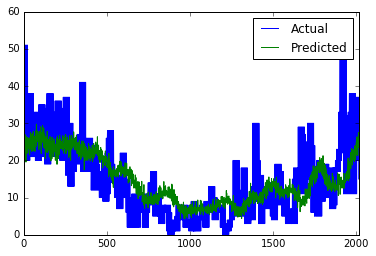

In [106]:
results = pd.concat([pd.Series(scaled_actuals), pd.Series(nn_preds)], axis=1)
results.columns = ["Actual", "Predicted"]
results.plot()

In [102]:
results.to_csv("predictions.csv")

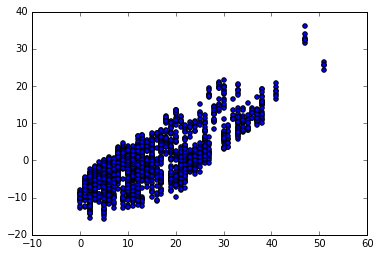

In [113]:
residuals = pd.Series(scaled_actuals) -  pd.Series(nn_preds)
plt.scatter(pd.Series(scaled_actuals),residuals)